In [1]:
import cartopy, cartopy.crs as ccrs
import matplotlib, matplotlib.pyplot as plt
import numba, numpy as np
import os, sys, re
import pandas as pd
import xarray as xr
import time
# Import local scripts
import accessor, utilities, visualization

import importlib
importlib.reload(utilities)
importlib.reload(visualization)

<module 'visualization' from '/projects/GEOCLIM/gr7610/scripts/visualization.py'>

In [2]:
############################################################
# Begin numba-specific parallelization methods.

@numba.njit
def apply_along_axis_0(func1d, arr):
    """Like calling func1d(arr, axis=0)"""
    if arr.size == 0:
        raise RuntimeError("Must have arr.size > 0")
    ndim = arr.ndim
    if ndim == 0:
        raise RuntimeError("Must have ndim > 0")
    elif 1 == ndim:
        return func1d(arr)
    else:
        result_shape = arr.shape[1:]
        out = np.empty(result_shape, arr.dtype)
        _apply_along_axis_0(func1d, arr, out)
        return out

@numba.njit
def _apply_along_axis_0(func1d, arr, out):
    """Like calling func1d(arr, axis=0, out=out). Require arr to be 2d or bigger."""
    ndim = arr.ndim
    if ndim < 2:
        raise RuntimeError("_apply_along_axis_0 requires 2d array or bigger")
    elif ndim == 2:  # 2-dimensional case
        for i in range(len(out)):
            out[i] = func1d(arr[:, i])
    else:  # higher dimensional case
        for i, out_slice in enumerate(out):
            _apply_along_axis_0(func1d, arr[:, i], out_slice)

@numba.njit
def nb_mean_axis_0(arr):
    return apply_along_axis_0(np.nanmean, arr)
    
# End numba-specific parallelization methods.
############################################################

In [3]:
def data_access(model, domain, field, frequency='month', vertical_level=None, resample=True, years=[100, 150]):
    dirname = '/projects/GEOCLIM/gr7610/analysis/model_out'
    experiments = ['control', 'swishe']

    print(years)

    data, derived_field_list = {}, derived_fields()
    
    derived = False
    if field in derived_field_list.keys():
        derived = True
        for experiment in experiments:
            data[experiment] = {}
            for subfield in derived_field_list[field]['fields']:
                data[experiment][subfield] = None
                if 'swishe' in experiment:
                    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                             (model in file) & (domain in file) & (subfield in file) & (frequency in file) & 
                             ('swishe' in file) & ('resample' in file) & (file.endswith('nc')) & (str(min(years)) in file) & (str(max(years)) in file)]
                else:
                    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                             (model in file) & (domain in file) & (subfield in file) & (frequency in file) & ('ens_' not in file) &
                             ('swishe' not in file) & ('resample' in file) & (file.endswith('nc')) & (str(min(years)) in file) & (str(max(years)) in file)]
                
                # Select vertical level
                for file in sorted(files):
                    if vertical_level and vertical_level in file:
                        print(file)
                        data[experiment][subfield] = xr.open_dataset(file)
                    elif 'full' in file:
                        print(file)
                        temp = xr.open_dataset(file)
                        if domain == 'atmos' and 'pfull' in temp.dims:
                            level_num = float(re.sub('\D', '', level))
                            data[experiment][subfield] = temp.sel(pfull=level_num, method='nearest')
                        elif domain == 'ocean' and 'st_ocean' in temp.dims:
                            data[experiment][subfield] = temp.sel(st_ocean=level_num, method='nearest')
                        else:
                            data[experiment][subfield] = temp
                            
    else:
        for experiment in experiments:
            if 'swishe' in experiment:
                files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                         (model in file) & (domain in file) & (field in file) & (frequency in file) & ('ens_' not in file) & 
                         ('swishe' in file) & ('resample' in file) & (file.endswith('nc')) & (str(min(years)) in file) & (str(max(years)) in file)]
            else:
                files = [os.path.join(dirname, file) for file in os.listdir(dirname) if
                         (model in file) & (domain in file) & (field in file) & (frequency in file) & ('ens_' not in file) & 
                         ('swishe' not in file) & ('resample' in file) & (file.endswith('nc')) & (str(min(years)) in file) & (str(max(years)) in file)]

            print(files)
            # Select vertical level
            for file in sorted(files)[::-1]:
                level_num = float(re.sub('\D', '', str(vertical_level))) if vertical_level else None
                if vertical_level and vertical_level in file:
                    data[experiment] = xr.open_dataset(file)
                    print('-->', file)
                elif 'full' in file:
                    temp = xr.open_dataset(file)
                    if domain == 'atmos' and 'pfull' in temp.dims:
                        data[experiment] = temp.sel(pfull=level_num, method='nearest')
                    elif domain == 'ocean' and 'st_ocean' in temp.dims:
                        data[experiment] = temp.sel(st_ocean=level_num, method='nearest')
                    else:
                        data[experiment] = temp
                    print('-->', file)

            if domain == 'ocean':
                data[experiment]['xt_ocean'] = np.where(data[experiment].xt_ocean < 0, 
                                                        data[experiment].xt_ocean + 360, 
                                                        data[experiment].xt_ocean)
                data[experiment] = data[experiment].sortby('xt_ocean')
                if 'st_ocean' in data[experiment].dims:
                    data[experiment] = data[experiment].rename({'xt_ocean': 'grid_xt', 'yt_ocean': 'grid_yt', 'st_ocean': 'pfull'})
                else:
                    data[experiment] = data[experiment].rename({'xt_ocean': 'grid_xt', 'yt_ocean': 'grid_yt'})
    
    return data, derived

In [4]:
def bootstrap_3d(a, b, plane=None, N=10000, level=0.95):
    '''
    Method to run bootstrap statistical testing on 3-dimensional model output. Dimensions include time, grid_xt (longitude), grid_yt (latitude).
    Current method diagnoses difference in means and establishes statistical significance for a given level from 0 to 1.
    Uses a 2-tailed approach.
    Parallel approach produces a speedup of ~4x.
    See Delsole and Tippett (2013), Chapter 3.6 for details.
    '''

    # Extract correct dimensions by checking to make sure data dimensions
    for dataset in [a, b]:
        # x-y planar data
        if ((plane == 'xy') or (plane is None)) and ('grid_xt' in dataset.dims) and ('grid_yt' in dataset.dims) and ('time' in dataset.dims):
            time_axis, x_axis, y_axis = a.dims.index('time'), a.dims.index('grid_xt'), a.dims.index('grid_yt')
        # y-z planar data 
        elif (plane == 'yz') and ('grid_yt' in dataset.dims) and ('pfull' in dataset.dims) and ('time' in dataset.dims):
            time_axis, x_axis, y_axis = a.dims.index('time'), a.dims.index('grid_yt'), a.dims.index('pfull')
        # x-z planar data
        elif (plane == 'xz') and ('grid_xt' in dataset.dims) and ('pfull' in dataset.dims) and ('time' in dataset.dims):
            time_axis, x_axis, y_axis = a.dims.index('time'), a.dims.index('grid_xt'), a.dims.index('pfull')
        else:
            print('Incorrect dimensions provided. Please check data for correct dimensions.')
            return None
            
    # Extract numeric values from the xArray Datasets
    x, y = a.values, b.values
    # Initialize empty arrays to contain output data
    out_x, out_y = [np.full((N, x.shape[y_axis], x.shape[x_axis]), np.nan), 
                    np.full((N, y.shape[y_axis], y.shape[x_axis]), np.nan)]

    @numba.njit(parallel=True)
    def bootstrap_resample(in_x, in_y, out_x, out_y, N):
        for repetition in numba.prange(0, N):
            out_x_temp, out_y_temp = np.full(in_x.shape, np.nan, dtype=np.float32), np.full(in_y.shape, np.nan, dtype=np.float32)
            for k in range(0, in_x.shape[time_axis]):
                out_x_temp[k] = in_x[np.random.randint(0, in_x.shape[time_axis]), :, :]
                out_y_temp[k] = in_y[np.random.randint(0, in_y.shape[time_axis]), :, :]
            out_x[repetition, :, :] = nb_mean_axis_0(out_x_temp)
            out_y[repetition, :, :] = nb_mean_axis_0(out_y_temp)
        return out_x, out_y

    out_x, out_y = bootstrap_resample(x, y, out_x, out_y, N)
    
    # Get difference between datasets
    delta = out_x - out_y # Control - SWISHE
    # Get values at each respective tail 
    ci_min, ci_max = np.quantile(delta, (1 - level)/2, axis=0), np.quantile(delta, (1 + level)/2, axis=0)
    # Wherever the signs are equal, output the mean. 
    # This indicates that the confidence interval does not intersect 0, such that the null hypothesis is rejected.
    out_binary = np.where(np.sign(ci_min) == np.sign(ci_max), 1, np.nan).T
    out_full = np.where(np.sign(ci_min) == np.sign(ci_max), np.nanmedian(delta, axis=0), np.nan).T
    median = np.nanmedian(delta, axis=0).T

    return out_binary, out_full, median, delta, ci_min, ci_max

In [5]:
def derived_fields():
    
    fields = {'p-e': {'fields': ['precip', 'evap'],
                      'attrs': {'long_name': 'precipitation - evaporation',
                                'units': 'mm d^-1'}},
              'theta_e': {'fields': ['sphum', 'temp', 'rh'],
                          'attrs': {'long_name': 'equivalent potential temperature',
                                    'units': 'K'}}}
    return fields 

In [6]:
def prune(data, field, vertical_level=None, plane='xy', extent=None, months=(1, 13), coarsen_factor=None):
    start_month, end_month = min(months), max(months)
    if not extent:
        extent = {'min_lon': 0, 'max_lon': 359, 'min_lat': -60, 'max_lat': 60}
    if not coarsen_factor:
        coarsen_factor = {'x': 2, 'y': 2, 'z': 1}
    if not vertical_level and plane == 'xy':
        vertical_level = 500
        print('Using default pressure level of 500 hPa...')

    outputs = {}
    derived_field_list = derived_fields()
    for experiment in data.keys():
        fields = [f if field in derived_field_list.keys() else field for f in data[experiment].keys()]
        print(fields, extent)
        outputs[experiment] = {}
        for subfield in fields:
            if 'pfull' in data['control'][subfield].dims:
                if plane == 'xy':
                    outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon'])).sel(grid_yt=slice(extent['min_lat'], extent['max_lat'])).sel(pfull=vertical_level, method='nearest').sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_xt=coarsen_factor['x'], grid_yt=coarsen_factor['y']).mean()
                    outputs[experiment][subfield] = outputs[experiment][subfield].transpose('time', 'grid_yt', 'grid_xt').drop_duplicates('time')
                elif plane == 'yz':
                    outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon'])).mean(dim='grid_xt').sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_yt=coarsen_factor['y'], pfull=coarsen_factor['z']).mean()
                    outputs[experiment][subfield] = outputs[experiment][subfield].transpose('time', 'grid_yt', 'pfull').drop_duplicates('time')
                elif plane == 'xz':
                    outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon'])).mean(dim='grid_yt').sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_xt=coarsen_factor['x'], pfull=coarsen_factor['z']).mean()
                    outputs[experiment][subfield] = outputs[experiment][subfield].transpose('time', 'grid_xt', 'pfull').drop_duplicates('time')
            else:
                outputs[experiment][subfield] = data[experiment][subfield].sel(grid_xt=slice(extent['min_lon'], extent['max_lon']), grid_yt=slice(extent['min_lat'], extent['max_lat'])).sel(time=utilities.month_selector(data[experiment][subfield]['time.month'], start_month, end_month)).coarsen(grid_xt=coarsen_factor['x'], grid_yt=coarsen_factor['y'], boundary='trim').mean().drop_duplicates('time')
        outputs[experiment] = xr.merge(outputs[experiment].values())
    return outputs

In [7]:
def derived(data, field, plane='xy'):
    
    derived_fields_list = derived_fields()
    outputs = {}
    
    for experiment in data.keys():
        outputs[experiment] = {}
        if field == 'p-e':
            outputs[experiment][field] = data[experiment]['precip'] - data[experiment]['evap']
        if field == 'theta_e':
            R_d, R_v, L_v, c_pd, c_l = 287, 461.5, 2.501e6, 1005.7, 4190
            r = data[experiment]['sphum']/(1 - data[experiment]['sphum'])
            c_tot = (c_pd + c_l*r)
            a, b = R_d/c_tot, -r*R_v/c_tot
            outputs[experiment][field] = (data[experiment]['temp']*(1000/data[experiment]['temp'].pfull)**a) * (data[experiment]['rh']**b) * np.exp(L_v*r/(c_tot*data[experiment]['temp']))
            outputs[experiment][field] = outputs[experiment][field].where(outputs[experiment][field].pfull >= 85, np.nan)
            outputs[experiment][field] = outputs[experiment][field].dropna(dim='time', how='all').dropna(dim='pfull', how='all')
        try:
            outputs[experiment][field].attrs = derived_fields_list[field]['attrs']
        except:
            print(outputs)

    return outputs

In [8]:
def xy_plot(model_name, data, median, significance_field, field, ci=None, outliers=True, years=None, months=None, 
            extent=None, vertical_level=None, contour_levels=13, domain_average=True, extrema=None, dpi=96, 
            stipple_color='light', savefig=False):

    importlib.reload(visualization)

    # Define letters for subplot labeling
    letters = 'abcdefg'

    # Normalization factor to make moisture units more intuitive
    factor = 86400 if field in ['precip', 'evap', 'p-e'] else 1
    year_min, year_max = min(years), max(years)
    
    min_lon, max_lon, min_lat, max_lat = extent[0], extent[1], extent[2], extent[3]

    ncols = 3
    fig, grid = [plt.figure(dpi=dpi, figsize=(12, 2), constrained_layout=True), 
                 matplotlib.gridspec.GridSpec(nrows=1, ncols=ncols, width_ratios=(0.2, 0.2, 0.6), wspace=0.2, hspace=0)]
    # Define longitudinal offset
    longitude_offset = 180
    # Define projections (working and reference projections)
    proj, proj_ref = ccrs.PlateCarree(central_longitude=longitude_offset), ccrs.PlateCarree()

    data_control = {'mean': data['control'][field]*factor, 
                    'std': data['control'][field]*factor}
    data_swishe = {'mean': data['swishe'][field]*factor,
                    'std': data['swishe'][field]*factor}

    # Pre-define metadata
    long_name, units = data['control'][field].attrs['long_name'], data['control'][field].attrs['units'] if field not in ['precip', 'evap', 'p-e'] else 'mm d$^{-1}$'
    long_name, units = visualization.field_properties(field)
    # Define month string to print
    months = range(min(months), max(months)+1)
    month_str = 'annual' if (months == None or (min(months) == 1 and max(months) == 12)) else ''.join([utilities.month_letter(month) for month in months])

    # Define line plot y-axis ticks
    y_step_major, y_step_minor = 20, 10
    gridline_y_major, gridline_y_minor = [np.arange(min_lat, max_lat + y_step_major, y_step_major), 
                                          np.arange(min_lat, max_lat + y_step_minor, y_step_minor)]
    # Iterate through subplots and define
    for i in range(0, ncols): 
        # Raw comparison
        if i == 0:
            ax = fig.add_subplot(grid[0, 0])
            ax.axhline(0, lw=0.5, alpha=0.5, c='k')
            # Plot line plots of zonal means
            im = ax.plot(data_control['mean'].mean(dim='grid_xt').mean(dim='time'), data_control['mean'].grid_yt, lw=2, c='b', ls='-', label='Control')
            im = ax.plot(data_swishe['mean'].mean(dim='grid_xt').mean(dim='time'), data_swishe['mean'].grid_yt, lw=2, c='r', ls='--', label='SWISHE')
            # Plot formatting
            ax.set_ylim([min_lat, max_lat])
            ax.set_xlabel('{0} [{1}]'.format(field, units), labelpad=10)
            ax.set_ylabel('Latitude')
            ax.set_title('Zonal means', loc='left', fontsize=10)
            # Define ticks
            ax.set_yticks(gridline_y_major)
            # Set minor ticks
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(gridline_y_minor))
            ax.grid(alpha=0.25, ls='--', which='both')
            ax.annotate('({0})'.format(letters[i]), xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')

        # Difference
        elif i == 1:
            ax = fig.add_subplot(grid[0, 1])
            ax.axhline(0, lw=0.5, alpha=0.5, c='k')
            ax.axvline(0, lw=0.5, alpha=0.5, c='k')
            # Get difference
            delta = data['control'][field].mean(dim='grid_xt').mean(dim='time')*factor - data['swishe'][field].mean(dim='grid_xt').mean(dim='time')*factor
            # 5-degree rolling mean for 0.5-degree resolution data
            delta = delta.rolling(grid_yt=10, center=True).mean()
            ax.plot(delta, data['control'][field].grid_yt, lw=2, c='k')
            ax.set_ylim([min_lat, max_lat])
            ax.set_xlabel('$\Delta$({0}) [{1}]'.format(field, units), labelpad=10)
            ax.set_title('Zonal mean difference', loc='left', fontsize=10)

            # Define ticks
            ax.set_yticks(gridline_y_major)
            # Set minor ticks
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(gridline_y_minor))
            ax.grid(alpha=0.25, ls='--', which='both')
            ax.annotate('({0})'.format(letters[i]), xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')
            ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

        # 2D map
        else:
            # Initialize subplot
            level_str = '' if not vertical_level else ', {0}'.format(vertical_level)
            fig, grid, ax, proj_ref = visualization.basemap(fig, grid, model_name, 'Control - SWISHE{0}, {1}'.format(level_str, month_str), year_range=(year_min, year_max),
                                                            row_num=0, col_num=2, extent=extent, land=True, ylabel=False)
            
            ax = fig.add_subplot(grid[0, -1], projection=proj)

            if not outliers:
                mean, std = np.nanmean(median), np.nanstd(median)
                median = np.where((median > (mean - 3*std)) & (median < (mean + 3*std)), median, np.nan)

            # Get colormap and normalization
            norm, cmap = visualization.norm_cmap(median, field, num_bounds=contour_levels, extrema=extrema, white_adjust=True)
            
            # Plot the data
            im = ax.contourf(data['control'][field].grid_xt, data['control'][field].grid_yt, median.T*factor, 
                             cmap=cmap, norm=norm, levels=contour_levels, transform=proj_ref)
            
            X, Y = np.meshgrid(data['control'][field].grid_xt.values.ravel(), data['control'][field].grid_yt.values.ravel())
            stipple_cmap = 'Greys' if stipple_color == 'light' else 'Greys_r'
            stipple_alpha = 0.1 if 'omega' in field else 0.5
            ax.scatter(X.ravel()[::2], Y.ravel()[::2], c=significance_field.T.ravel()[::2], cmap=stipple_cmap, s=0.5,
                       linewidth=0.5, alpha=stipple_alpha, transform=ccrs.PlateCarree())
            ax.annotate('({0})'.format(letters[i]), xy=(0.01, 0.03), xycoords='axes fraction', ha='left', va='bottom')
            
            del X, Y
            
            cax = ax.inset_axes([1.03, 0, 0.03, 1])
            colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
            
            colorbar.set_label('{0}\n[{1}]'.format(long_name, units), labelpad=30, rotation=270, fontsize=9)
            if field == 'sphum':
                cax.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3))
                t = cax.yaxis.get_offset_text()
                t.set_x(1.5)
                t.set_fontsize(8)
            
            ax.add_feature(cartopy.feature.LAND, color=(0.5, 0.5, 0.5, 0.25), zorder=99)
            ax.coastlines()

    # Figure saving
    if savefig:
        # Filename convention
        # model_{MODEL NAME}-result_{RESULT NAME}-type_{DOMAIN NAME}-var_{FIELD NAME}-level_{VERTICAL LEVEL}-years_s{START YEAR}_e{END YEAR}-months_s{START YEAR}_e{END YEAR}-ci_{CONFIDENCE INTERVAL}
        filename = 'model_{0}-result_Control_SWISHE-type_{1}-var_{2}-mean_month-level-{3}-years_s{4}_e{5}-months_s{6}_e{7}-ci_{8}.png'.format(model, domain, field, vertical_level, 
                                                                                                                                        year_min, year_max, min(months), max(months)+1, ci)
        dirname = '/projects/GEOCLIM/gr7610/figs/climate'
        plt.savefig(os.path.join(dirname, filename), dpi=300, bbox_inches='tight')

In [9]:
def reference_plots(data, median, ci=.95):

    ''' Control and experiment climatologies. '''
    
    fig, axes = plt.subplots(figsize=(10, 4), ncols=2, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    factor = 86400 if field in ['precip', 'evap'] else 1
    experiments = ['Control', 'SWISHE']
    
    n_bounds = 16
    if 'pfull' in data['control'].dims:
        bounds = [data['control'].sel(pfull=pressure_level, method='nearest').mean(dim='time')[field]*factor, 
                  data['swishe'].sel(pfull=pressure_level, method='nearest').mean(dim='time')[field]*factor]
    else:
        bounds = [data['control'].mean(dim='time')[field]*factor, data['swishe'].mean(dim='time')[field]*factor]
    
    if 'omega' in field:
        for i in range(0, len(bounds)):
            mean, std = np.nanmean(bounds[i]), np.nanstd(bounds[i])
            bounds[i] = np.where((bounds[i] > (mean - 3*std)) & (bounds[i] < (mean + 3*std)), bounds[i], np.nan)
    
    norm, cmap = visualization.norm_cmap(bounds, field, num_bounds=18, extrema=None, white_adjust=True)
    
    for i, ax in enumerate(fig.axes):
        im = ax.pcolormesh(data[experiments[i].lower()].grid_xt, data[experiments[i].lower()].grid_yt, 
                           bounds[i], norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
        ax.set_title(experiments[i], fontsize=10)
        ax.coastlines()
        
        gl = ax.gridlines(draw_labels=False, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator, gl.ylocator = matplotlib.ticker.FixedLocator([0]), matplotlib.ticker.FixedLocator([0])
        
        cax = ax.inset_axes([0, -0.1, 1, 0.05])
        colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
        cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

    ''' Distribution bounds for simple difference. '''
    
    fig, axes = plt.subplots(figsize=(10, 4), ncols=2, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

    if 'omega' in field:
        mean, std = np.nanmean(median), np.nanstd(median)
        median = np.where((median > (mean - 3*std)) & (median < (mean + 3*std)), median, np.nan)
    
    factor = 86400 if field in ['precip', 'evap', 'p-e'] else 1
    norm, cmap = visualization.norm_cmap(median*factor, field, num_bounds=18, extrema=None, white_adjust=True)
    bounds = [ci_min, ci_max]
    x_, y_ = data['control'][field], data['swishe'][field]
    
    for i, ax in enumerate(fig.axes):
        im = ax.pcolormesh(x_.grid_xt, y_.grid_yt, bounds[i]*factor, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        ax.set_title('{0:.1f}th percentile'.format(100*(1+(2*(i-0.5))*ci)/2), fontsize=10)
        ax.coastlines()
    
        gl = ax.gridlines(draw_labels=False, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator, gl.ylocator = matplotlib.ticker.FixedLocator([0]), matplotlib.ticker.FixedLocator([0])
        
        cax = ax.inset_axes([0, -0.1, 1, 0.05])
        colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
        long_name, units = x_.attrs['long_name'], x_.attrs['units'] if field not in ['precip', 'evap'] else 'mm d^-1'
        colorbar.set_label('{0} [{1}]'.format(long_name, units))
        cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

In [10]:
def main(model_name, field, vertical_level=None, domain='atmos', 
         month_range=(1, 12), plane='xy', extent=[0, 359, -60, 60], coarsen_factor=[4, 4, 4],
         N=1000, ci=0.95, years=(101, 150)):

    start_time = time.time()
    start_month, end_month = min(month_range), max(month_range)
    
    extent = {'min_lon': extent[0], 'max_lon': extent[1], 'min_lat': extent[2], 'max_lat': extent[3]}
    coarsen_factor = {'x': coarsen_factor[0], 'y': coarsen_factor[1], 'z': coarsen_factor[2]}

    raw, derived_boolean = data_access(model_name, domain, field, frequency='month', vertical_level=vertical_level, resample=True, years=years)
    pruned = prune(raw, field, vertical_level=vertical_level, plane=plane, 
                   extent=extent, months=(start_month, end_month), coarsen_factor=coarsen_factor)
    if derived_boolean:
        data = derived(pruned, field)
    else:
        data = pruned.copy()
        
    stipple, median_mask, median, delta, ci_min, ci_max = bootstrap_3d(data['control'][field], data['swishe'][field],
                                                                       plane=plane, N=N, level=ci)
    
    print('Runtime: {0:.2f} s'.format(time.time() - start_time))
    
    return data, stipple, median_mask, median, delta, ci_min, ci_max

In [73]:
model = 'AM2.5'
field = 'swup_toa'
level = None
domain = 'atmos'
extent = [0, 359, -60, 60]
months = (1, 12)
years = [101, 150]
ci = 0.95

data, stipple, median_mask, median, delta, ci_min, ci_max = main(model, field, vertical_level=level, domain=domain, 
                                                                 month_range=months, plane='xy', extent=extent, 
                                                                 coarsen_factor=[2, 2, 2], N=1000, ci=ci, years=years)

for experiment in data.keys():
    for k, v in data[experiment].items():
        data[experiment][k].name = k
    data[experiment] = xr.merge(data[experiment].values())

[101, 150]
['/projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_swup_toa-mean_month-resample-full-101_150.nc']
--> /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s-type_atmos-var_swup_toa-mean_month-resample-full-101_150.nc
['/projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s_swishe-type_atmos-var_swup_toa-mean_month-resample-full-101_150.nc']
--> /projects/GEOCLIM/gr7610/analysis/model_out/model_AM2.5-exp_CTL1990s_swishe-type_atmos-var_swup_toa-mean_month-resample-full-101_150.nc
Using default pressure level of 500 hPa...
['swup_toa'] {'min_lon': 0, 'max_lon': 359, 'min_lat': -60, 'max_lat': 60}
['swup_toa'] {'min_lon': 0, 'max_lon': 359, 'min_lat': -60, 'max_lat': 60}
Runtime: 21.20 s


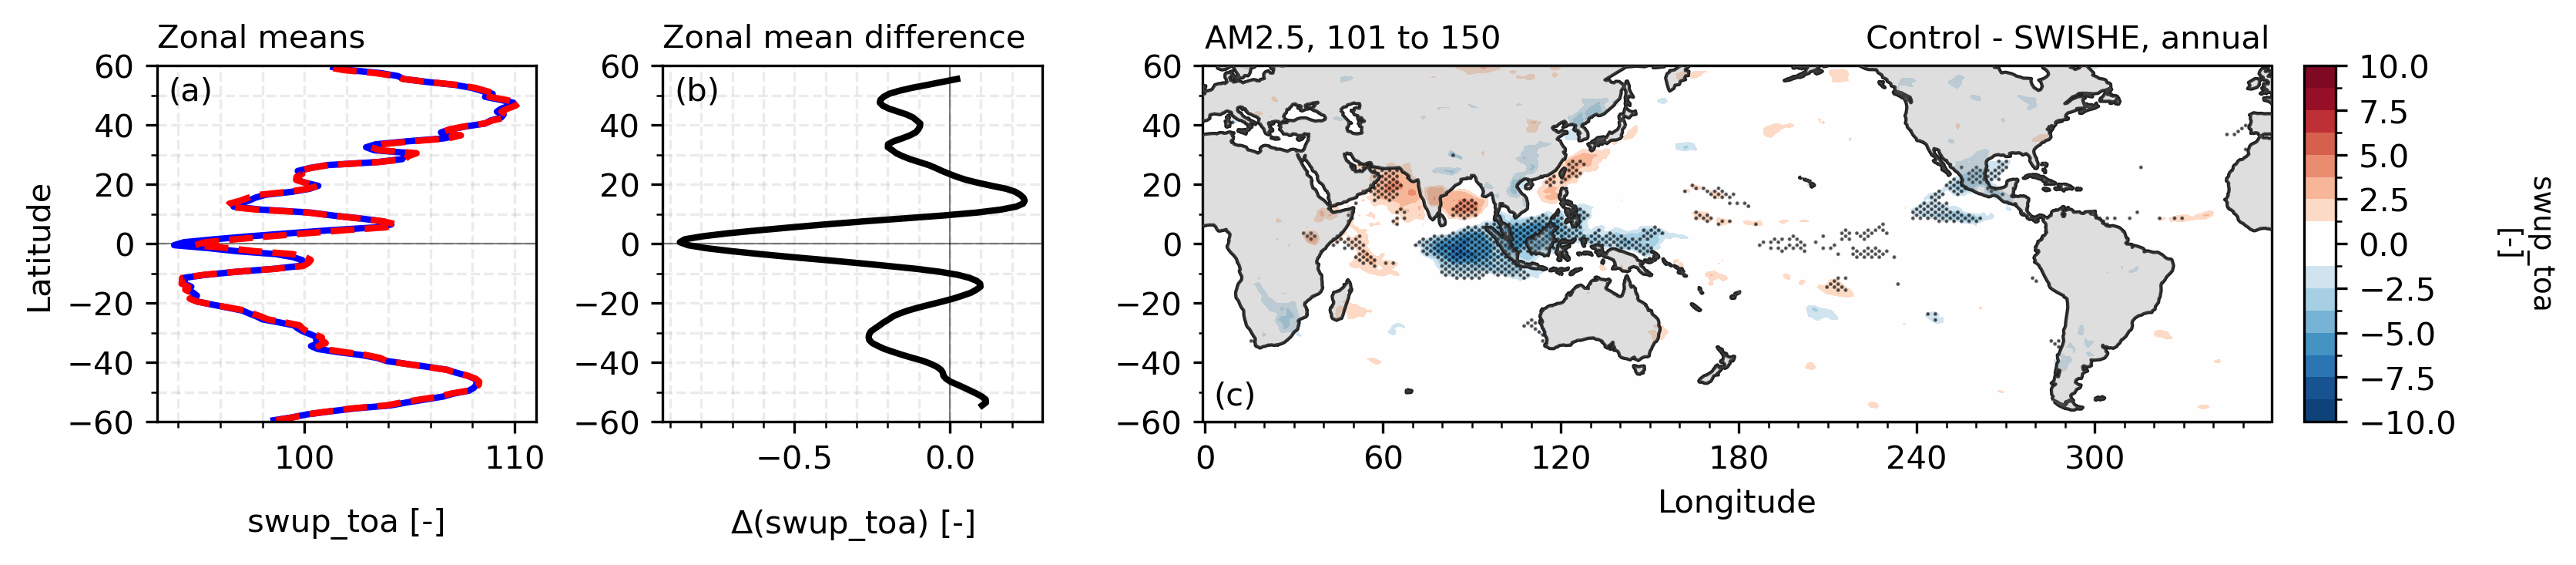

In [74]:
xy_plot(model, data, median, stipple, field, years=years, months=months, ci=ci,
        extent=extent, vertical_level=level, contour_levels=18, domain_average=True, extrema=[-10, 10], dpi=300, 
        stipple_color='dark', outliers=True, savefig=False)

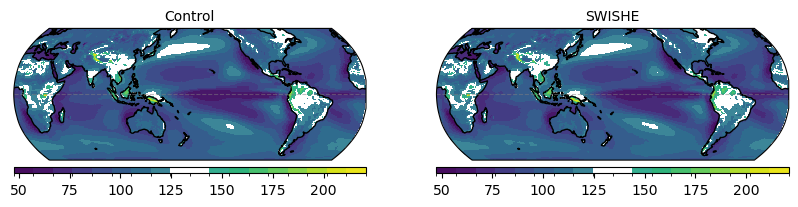

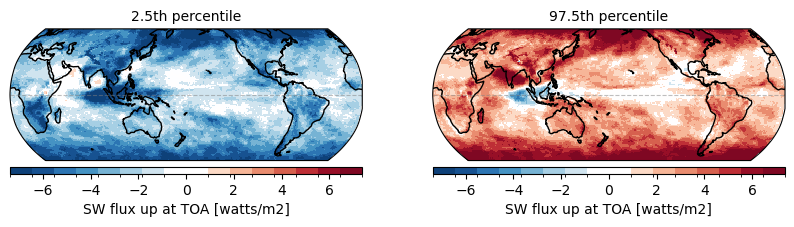

In [75]:
reference_plots(data, median)